# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on qualifying, test on race

In [92]:
disable_gpu = False
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget

import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  

import tensorflow as tf

if disable_gpu:
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    tf.config.set_visible_devices([], 'GPU')
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow import keras
import keras_tuner
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append(os.environ['f1_install'])
from tools.fastf1_tools import loadTelemForYear, loadTelemForEvent

plt.ion()


# https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available: {}'.format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Set seed for reproducable testing
np.random.seed(0)

Number of GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [93]:


# Get speed traces for Max in Abu Dhabi 2022 GP
schedule = fastf1.get_event_schedule(year=2022, include_testing=False)
event = schedule.get_event_by_round(1)
session = event.get_session('R')
session.load()
driver_info = fastf1.api.driver_info(session.api_path)
all_drivers = np.asarray([d['Tla'] for i, d in driver_info.items()])

path = os.path.join(os.environ['f1_install'], 'dataframes')
telem_param = 'Speed'

refined_laps = loadTelemForEvent(event, path=path, telem_param=telem_param) # Formatted laps generated by ml/save_lap_telemetry.py


# Simplify the problem down to a handful of drivers first
choose_drivers = ['VER', 'HAM']#all_drivers#['VER', 'HAM', 'LEC','BOT','SAI','RUS']

columns = refined_laps.columns[[np.isin(c.split('_')[0], choose_drivers) for c in refined_laps.columns]]
refined_laps = refined_laps[columns]
all_drivers = choose_drivers

# print(refined_laps.head())


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
api            INFO 	Using cached data for driver_info


Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Bahrain_Grand_Prix_2022.pkl


Here we randomize the lap order.

In [94]:

randomized_indices = np.random.choice(range(len(refined_laps.columns)), len(refined_laps.columns))
refined_laps = refined_laps.iloc[:, randomized_indices]# Shuffled randomly
refined_laps = refined_laps.dropna() # Will cut off laps beyond shortest lap of the season.  But is a quick way to normalize data. 

print(refined_laps.head().T.head(4).T) #Print the head of the first 4 laps

                             VER_2       VER_5      VER_24      VER_27
0 days 00:00:00         276.000000  277.333333  277.333333  279.000000
0 days 00:00:00.100000  276.750000  278.333333  278.708333  279.750000
0 days 00:00:00.200000  278.307692  279.487179  280.294872  280.615385
0 days 00:00:00.300000  279.225000  279.833333  281.445833  281.550000
0 days 00:00:00.400000  279.966942  280.614325  282.486226  282.185950


Next we quickly plot the laps, helpful for checking the data is sensible.  

Text(0.5, 1.0, 'Driver Lap Times For Loaded Session\n(Normal Conditions)')

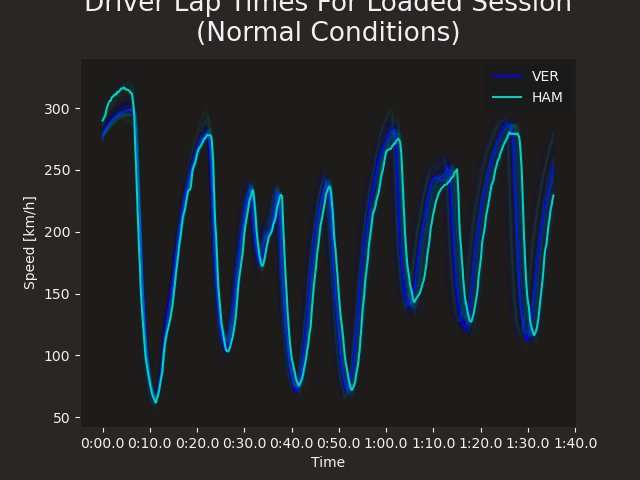

In [95]:
# Quickly plot laps
plt.figure()

for driver in all_drivers:
    driver_laps = refined_laps.loc[:, refined_laps.columns.str.match('{}*'.format(driver))]
    laptimes = driver_laps.notna()[::-1].idxmax()
    min_lap = laptimes.argmin()
    max_lap = laptimes.argmax()
    for i, (lap_name, lap) in enumerate(driver_laps.iteritems()):
        plt.plot(lap, alpha=1.0 if i == min_lap else 1.0/len(driver_laps.columns), c=fastf1.plotting.driver_color(driver), label=driver if i == min_lap else None)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Speed [km/h]')
plt.xlabel('Time')
plt.title('Driver Lap Times For Loaded Session\n(Normal Conditions)')

### Status
At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.

# Machine Learning Descrimination

Below is where I begin playing with actual ML code.

## Preparing Data
The data must be represented as normalized arrays, with features like driver id's being integers.  This is done below.


In [96]:
# Get numpy array where each row is lap, and obtain labels. 
np_laps = refined_laps.to_numpy().T #Will cut off laps longer than shortest lap in the calander.
labels = np.asarray([c.split('_')[0] for c in refined_laps.columns]) # np.asarray([np.where(all_drivers == c.split('_')[0])[0][0] for c in refined_laps.columns]) # Each driver associated with an integer.

training_percent = 0.8

training_n = int(training_percent*len(refined_laps.columns))
training_indices = np.random.choice(range(len(refined_laps.columns)), size=training_n, replace=False)

testing_indices = np.arange(len(refined_laps.columns))[~np.isin(np.arange(len(refined_laps.columns)), training_indices)]

print('Training on {} laps, and testing on {}'.format(len(training_indices), len(testing_indices)))


Training on 68 laps, and testing on 17


In [97]:
# Prepare preprocessing
scaler = keras.layers.Rescaling(scale=1.0/np.nanmax(np_laps))
vectorizer = keras.layers.TextVectorization(output_mode="int")
vectorizer.adapt(np.unique(labels))
num_classes = len(np.unique(labels))

# Prepare Training Data
training_labels = vectorizer(labels[training_indices]) - 2
training_data = scaler(np_laps[training_indices])#tf.convert_to_tensor(np_laps[training_indices])

# # Preparing Testing Data
testing_labels = vectorizer(labels[testing_indices]) - 2
testing_data = scaler(np_laps[testing_indices])#tf.convert_to_tensor(np_laps[testing_indices])

label_key = vectorizer.get_vocabulary()[2:] #Strip off the '' and 'UNK' options.


def_function    WARNING 	5 out of the last 5 calls to <function PreprocessingLayer.make_adapt_function.<locals>.adapt_step at 0x000002DFDA4268B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


## Preparing Model
Now we start preparing the model.

In [125]:
if True:
    model = keras.models.Sequential([
        keras.layers.Dense(units=50, activation='tanh', input_shape=(training_data.shape[1],)),
        keras.layers.Dense(units=16, activation='tanh'),
        keras.layers.Dense(units=32, activation='tanh'),
        keras.layers.Dense(units=40, activation='tanh'),
        keras.layers.Dense(units=len(all_drivers), activation='softmax')
        ])
else:
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=32, kernel_size=20, activation='relu', padding='same', input_shape=(training_data.shape[1],1,)),
        keras.layers.Dense(units=32, activation='tanh'),
        keras.layers.Dense(units=40, activation='tanh'),
        keras.layers.Dense(units=len(all_drivers), activation='softmax')
        ])

# optimizer = optimizers.Adam(clipvalue=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)#RMSprop
model.summary()
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['categorical_accuracy'])#mean_squared_error


print(training_data.shape)
print((None, training_data.shape[1:][0], 1))


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 50)                47800     
                                                                 
 dense_66 (Dense)            (None, 16)                816       
                                                                 
 dense_67 (Dense)            (None, 32)                544       
                                                                 
 dense_68 (Dense)            (None, 40)                1320      
                                                                 
 dense_69 (Dense)            (None, 2)                 82        
                                                                 
Total params: 50,562
Trainable params: 50,562
Non-trainable params: 0
_________________________________________________________________
(68, 955)
(None, 955, 1)


## Training Model

In [128]:
# Perform checks on data
assert np.any(np.isnan(training_data)) == False
assert np.any(np.isnan(training_labels)) == False
assert np.any(np.isnan(testing_data)) == False
assert np.any(np.isnan(testing_labels)) == False
assert type(training_data) == type(training_labels)

print('Training on {} laps, and testing on {}, attempting to distinguish between {} drivers.'.format(training_data.shape[0], testing_data.shape[0], len(np.unique(training_labels))))
model.fit(training_data, training_labels, batch_size=10, epochs=1000, verbose=2)#, validation_split=0.2

result = model.evaluate(testing_data,testing_labels,verbose=1)

# Changing the accuracy into a percentage
testing_acc = result[1]*100
# Printing the accuracy
print('Test Accuracy - ', testing_acc,'%')
print(dict(zip(model.metrics_names, result)))


Training on 68 laps, and testing on 17, attempting to distinguish between 2 drivers.
Epoch 1/1000
7/7 - 0s - loss: 0.7605 - categorical_accuracy: 0.0000e+00 - 34ms/epoch - 5ms/step
Epoch 2/1000
7/7 - 0s - loss: 0.6980 - categorical_accuracy: 0.7059 - 35ms/epoch - 5ms/step
Epoch 3/1000
7/7 - 0s - loss: 0.7065 - categorical_accuracy: 1.0000 - 32ms/epoch - 5ms/step
Epoch 4/1000
7/7 - 0s - loss: 0.6932 - categorical_accuracy: 0.5882 - 35ms/epoch - 5ms/step
Epoch 5/1000
7/7 - 0s - loss: 0.7114 - categorical_accuracy: 0.0000e+00 - 28ms/epoch - 4ms/step
Epoch 6/1000
7/7 - 0s - loss: 0.7261 - categorical_accuracy: 0.8529 - 31ms/epoch - 4ms/step
Epoch 7/1000
7/7 - 0s - loss: 0.6886 - categorical_accuracy: 0.8824 - 34ms/epoch - 5ms/step
Epoch 8/1000
7/7 - 0s - loss: 0.7445 - categorical_accuracy: 0.0000e+00 - 29ms/epoch - 4ms/step
Epoch 9/1000
7/7 - 0s - loss: 0.7171 - categorical_accuracy: 0.7059 - 27ms/epoch - 4ms/step
Epoch 10/1000
7/7 - 0s - loss: 0.7121 - categorical_accuracy: 1.0000 - 32ms

1/1 [==============================] - 0s 33ms/step - loss: 0.7187 - categorical_accuracy: 1.0000
{'loss': 0.7186790704727173, 'categorical_accuracy': 1.0}
tf.Tensor(
[[0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]
 [0.58662355 0.41337648]], shape=(17, 2), dtype=float32)
Actual driver was VER but this predicted VER
Actual driver was VER but this predicted VER
Actual driver was HAM but this predicted VER
Actual driver was VER but this predicted VER
Actual driver was HAM but this predicted VER
Actual driver was VER but this predicted VER
Actual driver was HAM but this predicted VER
Actual driver was HAM but this predicted VER
Actual driver wa

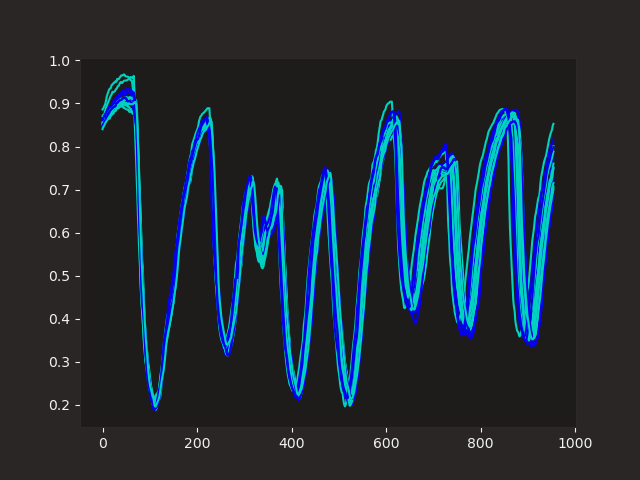

In [129]:
plt.figure()
result = model.evaluate(testing_data,testing_labels,verbose=1)
print(dict(zip(model.metrics_names, result)))
predictions = model(testing_data, training=False)
print(predictions)

# print('!!!')
# print(sum(training_labels.numpy() == 0)/len(training_labels), sum(training_labels.numpy() == 1)/len(training_labels))

for i in range(testing_data.shape[0]):
    driver = label_key[testing_labels.numpy()[i][0]].upper()
    predicted_driver = label_key[np.argmax(predictions[i])].upper()
    print('Actual driver was {} but this predicted {}'.format(driver, predicted_driver))
    plt.plot(testing_data.numpy()[i], c=fastf1.plotting.driver_color(driver), alpha=1.0)

# print(list(zip(testing_labels.numpy(), testing_data.numpy())))
print(predictions.shape)